
# Smoking & Drinking Risk — Teacher–Student (XGBoost) Pipeline
**Generated:** 2025-10-16 13:07  

Questo notebook implementa un flusso di **training con informazioni privilegiate** (Teacher–Student / Knowledge Distillation):  
- **Teacher model:** allena un regressore utilizzando **tutte** le feature (incluse cliniche/laboratorio) per predire un **indice di rischio** costruito dai marker clinici.  
- **Student model:** impara a **imitare** le predizioni del Teacher usando **solo feature semplici** (anagrafiche, antropometriche, pressione, vista/udito, fumo, alcol).  
- **Produzione:** in filiale si usa **solo lo Student**, senza esami del sangue.

Infine, si mappa l'`indice di rischio` ad un **premio assicurativo**.


## 1) Configurazione

In [7]:

# === Config ===
DATA_PATH = "smoking_driking_dataset_Ver01.csv"   # <-- Modifica qui il nome del tuo file CSV se diverso
SAVE_MODEL_DIR = "models"
BASE_PREMIUM = 500.0      # premio base (€/anno)
MAX_INCREASE = 0.8        # sovrapprezzo max = +80%

import os
os.makedirs(SAVE_MODEL_DIR, exist_ok=True)
print("Config ok.")


Config ok.


## 2) Import librerie

In [3]:

import numpy as np
import pandas as pd

# Matplotlib only (no seaborn), 1 plot per figure as required
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# XGBoost (fallback to GradientBoosting if unavailable)
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    from sklearn.ensemble import GradientBoostingRegressor

print("XGBoost available:", HAS_XGB)


XGBoost available: True


## 3) Caricamento dataset

In [8]:

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(991346, 24)


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


## 4) Pulizia e mappature

In [9]:

# Copia per sicurezza
df = df.copy()

# Mappa categorie note
if "DRK_YN" in df.columns:
    df["DRK_YN"] = df["DRK_YN"].map({"Y":1, "N":0}).astype("Int64")

# Sex -> 0/1 se possibile
if "sex" in df.columns:
    # tentativo robusto
    df["sex"] = df["sex"].astype(str).str.strip().str.lower()
    map_sex = {"male":1, "m":1, "1":1, "female":0, "f":0, "0":0}
    df["sex"] = df["sex"].map(lambda x: map_sex[x] if x in map_sex else np.nan)
    df["sex"] = df["sex"].astype("Float64")

# SMK_stat_type_cd già 1/2/3
if "SMK_stat_type_cd" in df.columns:
    df["SMK_stat_type_cd"] = pd.to_numeric(df["SMK_stat_type_cd"], errors="coerce").astype("Float64")

# Crea BMI se height/weight
if set(["height","weight"]).issubset(df.columns):
    h = pd.to_numeric(df["height"], errors="coerce")
    w = pd.to_numeric(df["weight"], errors="coerce")
    df["BMI"] = w / ( (h/100.0)**2 )
    df["BMI"] = df["BMI"].astype("Float64")

# Converte tutte le colonne numeriche possibili
for c in df.columns:
    if df[c].dtype == "object":
        try:
            df[c] = pd.to_numeric(df[c], errors="ignore")
        except Exception:
            pass

print("Valori nulli per colonna (prime 30):")
print(df.isnull().sum().sort_values(ascending=False).head(30))


Valori nulli per colonna (prime 30):
sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
BMI                 0
dtype: int64


## 5) Definizione gruppi di feature

In [10]:

# Feature "semplici" (disponibili in filiale)
simple_features = [
    col for col in [
        "sex","age","height","weight","waistline",
        "sight_left","sight_right","hear_left","hear_right",
        "SBP","DBP","SMK_stat_type_cd","DRK_YN","BMI"
    ] if col in df.columns
]

# Feature cliniche (laboratorio/urine/enzimi) — usate SOLO in training
candidate_clinical = [
    "HDL_chole","LDL_chole","triglyceride","hemoglobin",
    "urine_protein","serum_creatinine","SGOT_AST","SGOT_ALT","gamma_GTP"
]
clinical_features = [c for c in candidate_clinical if c in df.columns]

print("Simple features:", simple_features)
print("Clinical features:", clinical_features)

# Rimuove righe con NaN nelle feature usate dal teacher (per semplicità)
used_for_teacher = list(set(simple_features + clinical_features))
df_clean = df.dropna(subset=used_for_teacher).reset_index(drop=True)
print("Shape after dropna for teacher features:", df_clean.shape)


Simple features: ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'SMK_stat_type_cd', 'DRK_YN', 'BMI']
Clinical features: ['HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
Shape after dropna for teacher features: (991346, 25)


## 6) Costruzione target 'health_risk' via PCA sulle feature cliniche

In [11]:

# Standardizza le cliniche e applica PCA (1 componente)
scaler = StandardScaler()
X_clin = scaler.fit_transform(df_clean[clinical_features])

pca = PCA(n_components=1, random_state=42)
risk_raw = pca.fit_transform(X_clin).ravel()

# Normalizza su [0,1]
def minmax(x):
    x = np.asarray(x, dtype=float)
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-12)

df_clean["health_risk"] = minmax(risk_raw)

print("Varianza spiegata dalla prima componente PCA:", float(pca.explained_variance_ratio_[0]))
df_clean[["health_risk"]].describe()


Varianza spiegata dalla prima componente PCA: 0.24776778662025442


,health_risk
count,991346.000000
mean,0.227004
std,0.005319
min,0.000000
25%,0.223924
50%,0.226132
75%,0.228868
max,1.000000


## 7) Split train/val/test

In [12]:

# Train/Val/Test split sul teacher
X_teacher = df_clean[simple_features + clinical_features].values
y_teacher = df_clean["health_risk"].values

X_tr, X_te, y_tr, y_te = train_test_split(X_teacher, y_teacher, test_size=0.2, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

len_tr, len_va, len_te = len(y_tr), len(y_va), len(y_te)
print("Train/Val/Test sizes:", len_tr, len_va, len_te)


Train/Val/Test sizes: 634460 158616 198270


## 8) Training Teacher model (tutte le feature)

In [15]:
## 8) Training Teacher model (tutte le feature)

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from inspect import signature

# Se XGBoost è disponibile, usa XGBRegressor, altrimenti GradientBoosting
if HAS_XGB:
    teacher = xgb.XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
else:
    from sklearn.ensemble import GradientBoostingRegressor
    teacher = GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )

# Addestramento
teacher.fit(X_tr, y_tr)

# Predizioni
pred_va = teacher.predict(X_va)
pred_te = teacher.predict(X_te)

# Funzione di valutazione compatibile con tutte le versioni di scikit-learn
def reg_report(y_true, y_pred):
    # Controlla se la funzione supporta il parametro 'squared'
    if 'squared' in signature(mean_squared_error).parameters:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse
    }

# Stampa risultati
print("Teacher Val:", reg_report(y_va, pred_va))
print("Teacher Test:", reg_report(y_te, pred_te))


Teacher Val: {'R2': 0.8841470601767956, 'MAE': 0.00022748828766359458, 'RMSE': np.float64(0.0017955151858005587)}
Teacher Test: {'R2': 0.8470917031504612, 'MAE': 0.00022658906065413736, 'RMSE': np.float64(0.0021058107878646026)}


## 9) Training Student model (solo feature semplici) — distillazione

In [16]:

# Label distillate dal teacher su TUTTO df_clean
teacher_full_pred = teacher.predict(df_clean[simple_features + clinical_features].values)
df_clean["teacher_pred"] = teacher_full_pred

# Split per lo Student usando SOLO simple features
X_student_all = df_clean[simple_features].values
y_student_all = df_clean["teacher_pred"].values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_student_all, y_student_all, test_size=0.2, random_state=42)
Xs_tr, Xs_va, ys_tr, ys_va = train_test_split(Xs_tr, ys_tr, test_size=0.2, random_state=42)

if HAS_XGB:
    student = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
else:
    student = GradientBoostingRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )

student.fit(Xs_tr, ys_tr)

stu_va = student.predict(Xs_va)
stu_te = student.predict(Xs_te)

print("Student Val:", reg_report(ys_va, stu_va))
print("Student Test:", reg_report(ys_te, stu_te))


Student Val: {'R2': 0.3418753147125244, 'MAE': 0.002384589286521077, 'RMSE': np.float64(0.00402506241404321)}
Student Test: {'R2': 0.3424358367919922, 'MAE': 0.002381822792813182, 'RMSE': np.float64(0.004028080532133578)}


In [32]:
# === CALIBRAZIONE RISCHIO: ricava bound robusti e salvali nei metadati ===
import numpy as np, pickle, os

# Predizioni dello Student su tutta la popolazione "pulita"
student_preds_all = student.predict(df_clean[simple_features].values)

# Bound robusti (evita outlier): 5° e 95° percentile
p5  = float(np.percentile(student_preds_all, 5))
p95 = float(np.percentile(student_preds_all, 95))

# Carica e aggiorna metadati
with open("models/metadata.pkl", "rb") as f:
    meta = pickle.load(f)

meta["student_pred_p5"]  = p5
meta["student_pred_p95"] = p95

with open("models/metadata.pkl", "wb") as f:
    pickle.dump(meta, f)

print("Calibrazione salvata:")
print("P5 =", round(p5, 6), "  P95 =", round(p95, 6))


Calibrazione salvata:
P5 = 0.222595   P95 = 0.232046


## 10) Importanza feature (Student)

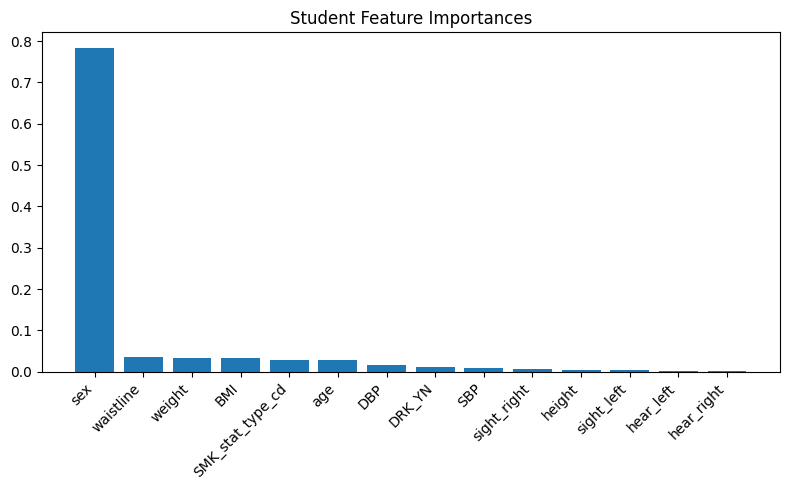

In [33]:

# Ottieni importanze (XGBoost o sklearn)
if HAS_XGB:
    importances = student.feature_importances_
else:
    importances = getattr(student, "feature_importances_", np.zeros(len(simple_features)))

# Ordina e plottalo con matplotlib
idx_sorted = np.argsort(importances)[::-1]
features_sorted = [simple_features[i] for i in idx_sorted]
importances_sorted = importances[idx_sorted]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances_sorted)), importances_sorted)
plt.xticks(range(len(importances_sorted)), features_sorted, rotation=45, ha="right")
plt.title("Student Feature Importances")
plt.tight_layout()
plt.show()


## 11) Funzione di pricing

In [34]:

def compute_premium(risk_index, base=BASE_PREMIUM, max_increase=MAX_INCREASE):
    # risk_index può essere fuori [0,1] -> clamp
    r = float(risk_index)
    r = max(0.0, min(1.0, r))
    return base * (1.0 + max_increase * r)

# Esempio su test set dello Student
risk_pred_test = student.predict(Xs_te)
# normalizzazione opzionale su [0,1]
risk_min, risk_max = np.min(risk_pred_test), np.max(risk_pred_test) + 1e-12
risk_norm = (risk_pred_test - risk_min) / (risk_max - risk_min)

premiums = [compute_premium(r) for r in risk_norm]
print("Esempio premi (prime 10):", premiums[:10])


Esempio premi (prime 10): [511.31992638111115, 522.6005226373672, 528.5227179527283, 525.4473000764847, 512.6868039369583, 524.98799264431, 507.1941748261452, 517.1302422881126, 513.0498930811882, 515.7945141196251]


## 12) Helper: predizione per un singolo cliente (solo feature semplici)

In [35]:

# Attenzione: lo Student è addestrato su df_clean (dopo dropna). 
# Per un cliente nuovo, bisogna passare esattamente le simple_features in questo ordine.

def predict_client_premium(client_dict):
    # Crea vettore nello stesso ordine delle simple_features
    x = []
    for col in simple_features:
        if col not in client_dict:
            raise ValueError(f"Manca la feature richiesta: {col}")
        x.append(client_dict[col])
    x = np.array(x).reshape(1, -1)
    # Predizione rischio dallo Student
    risk_pred = student.predict(x)[0]
    # Normalizzazione rispetto a train dello Student (usa le stesse statistiche del batch test come esempio)
    r = (risk_pred - risk_min) / (risk_max - risk_min)
    premium = compute_premium(r)
    return float(r), float(premium)

# Esempio di input (adatta ai tuoi dati reali)
example_client = {k: df_clean.iloc[0][k] for k in simple_features}
risk_idx, prem = predict_client_premium(example_client)
print("Risk index (normalized):", round(risk_idx, 3), " -> Premium (€):", round(prem, 2))


Risk index (normalized): 0.071  -> Premium (€): 528.39


## 13) Salvataggio modelli

In [36]:

import pickle

with open(os.path.join(SAVE_MODEL_DIR, "teacher_model.pkl"), "wb") as f:
    pickle.dump(teacher, f)
with open(os.path.join(SAVE_MODEL_DIR, "student_model.pkl"), "wb") as f:
    pickle.dump(student, f)

meta = {
    "simple_features": simple_features,
    "clinical_features": clinical_features,
    "pca_variance_explained": float(pca.explained_variance_ratio_[0]),
    "base_premium": BASE_PREMIUM,
    "max_increase": MAX_INCREASE,
    "has_xgboost": bool(HAS_XGB)
}
with open(os.path.join(SAVE_MODEL_DIR, "metadata.pkl"), "wb") as f:
    pickle.dump(meta, f)

print("Modelli salvati in:", SAVE_MODEL_DIR)


Modelli salvati in: models



## Note e miglioramenti possibili
- **Calibrazione premio:** valuta su dati storici sinistri/premi per tarare `BASE_PREMIUM` e `MAX_INCREASE`.
- **Explainability:** si può aggiungere SHAP (se disponibile) per spiegare le decisioni dello Student.
- **Validazione:** aggiungere K-Fold CV e metriche stabili per ridurre overfitting.
- **Robustezza:** gestire outlier, winsorization, e trasformazioni robuste su variabili con code pesanti.
- **Privacy:** i marker clinici sono usati solo in training (Teacher) e mai richiesti in filiale (Student).


In [30]:
# === PREDIZIONE DA MODELLO SALVATO: scegli i parametri del cliente ===
import pickle
import numpy as np

# 1) Carico modello e metadati salvati
with open("models/student_model.pkl", "rb") as f:
    student = pickle.load(f)

with open("models/metadata.pkl", "rb") as f:
    meta = pickle.load(f)

simple_features = meta["simple_features"]
BASE_PREMIUM = meta.get("base_premium", 500.0)
MAX_INCREASE = meta.get("max_increase", 0.8)

def compute_premium(risk_index, base=BASE_PREMIUM, max_increase=MAX_INCREASE):
    # clamp su [0,1] per sicurezza
    r = float(risk_index)
    r = max(0.0, min(1.0, r))
    return base * (1.0 + max_increase * r)

def _safe_float(x):
    return None if x is None else float(x)

def predict_client_premium_loaded(client_dict):
    """
    Usa il modello STUDENT salvato per predire:
    - risk_index (clamp in [0,1])
    - premio (euro)

    Requisiti:
      - Fornire le feature in client_dict per tutte le 'simple_features' (tranne BMI che è opzionale).
      - Se 'BMI' manca, viene calcolato da 'height' (cm) e 'weight' (kg) se presenti.
    """
    # Copia difensiva
    c = dict(client_dict)

    # Calcolo BMI se assente
    if "BMI" in simple_features and ("BMI" not in c or c["BMI"] in (None, "")):
        if "height" in c and "weight" in c and c["height"] not in (None,"") and c["weight"] not in (None,""):
            h_m = float(c["height"]) / 100.0
            c["BMI"] = float(c["weight"]) / (h_m ** 2)
        else:
            raise ValueError("BMI non fornito e non calcolabile: servono 'height' (cm) e 'weight' (kg).")

    # Costruisco il vettore X nello stesso ordine usato in training
    x = []
    for col in simple_features:
        if col not in c:
            raise ValueError(f"Manca la feature richiesta: '{col}'.")
        val = c[col]
        if val is None or val == "":
            raise ValueError(f"Valore mancante per feature '{col}'.")
        x.append(_safe_float(val))
    X = np.array(x, dtype=float).reshape(1, -1)

    # Predizione rischio grezzo
    risk_pred = float(student.predict(X)[0])

    # Nota: lo Student è stato addestrato a imitare un target in [0,1] (health_risk),
    # ma per sicurezza clampiamo in [0,1] nel caso di piccole uscite fuori range.
    risk_index = max(0.0, min(1.0, risk_pred))

    # Premio
    premium = compute_premium(risk_index, base=BASE_PREMIUM, max_increase=MAX_INCREASE)
    return risk_index, premium

# =========== ESEMPIO: modifica questi parametri con i dati del cliente ===========
# Convenzioni:
#  - sex: 1 = uomo, 0 = donna
#  - SMK_stat_type_cd: 1=never, 2=ex-smoker, 3=smoker
#  - DRK_YN: 1=drinker, 0=non-drinker
new_client = {
    "sex": 1,
    "age": 45,
    "height": 160,     # cm
    "weight": 60,      # kg
    "waistline": 94,   # cm
    "sight_left": 1.0,
    "sight_right": 1.0,
    "hear_left": 1.0,
    "hear_right": 1.0,
    "SBP": 125,
    "DBP": 80,
    "SMK_stat_type_cd": 1,
    "DRK_YN": 0,
    # "BMI": 85/(1.78**2)   # opzionale: se non lo metti, lo calcola
}

worst_client = {
    "sex": 1,                # maschio
    "age": 70,
    "height": 165,
    "weight": 110,
    "waistline": 115,
    "sight_left": 0.5,
    "sight_right": 0.5,
    "hear_left": 0.5,
    "hear_right": 0.5,
    "SBP": 160,
    "DBP": 100,
    "SMK_stat_type_cd": 3,   # fumatore attuale
    "DRK_YN": 1,             # bevitore
    # BMI verrà calcolato automaticamente
}

risk_idx, premium = predict_client_premium_loaded(new_client)
print(f"Indice rischio (clamped): {risk_idx:.3f}")
print(f"Premio stimato: € {premium:.2f}  (Base={BASE_PREMIUM}, MaxIncrease={MAX_INCREASE*100:.0f}%)")
print("=========================================")
risk_idx, premium = predict_client_premium_loaded(worst_client)
print(f"Indice rischio: {risk_idx:.3f}")
print(f"Premio stimato: € {premium:.2f}")


Indice rischio (clamped): 0.230
Premio stimato: € 591.92  (Base=500.0, MaxIncrease=80%)
Indice rischio: 0.231
Premio stimato: € 592.27


In [31]:
# ================== PRICING A FASCE + ESEMPI DIMOSTRATIVI ==================
import pickle
import numpy as np
import os

# 1) (Ri)carica modello e metadati se non sono in RAM
if "student" not in globals() or "meta" not in globals():
    with open("models/student_model.pkl", "rb") as f:
        student = pickle.load(f)
    with open("models/metadata.pkl", "rb") as f:
        meta = pickle.load(f)

simple_features = meta["simple_features"]
BASE_PREMIUM = meta.get("base_premium", 500.0)

# 2) Definisci fasce e moltiplicatori (puoi personalizzare)
TIERS = [
    # (nome_fascia, soglia_superiore_inclusiva, moltiplicatore_premio)
    ("Bronze", 0.33, 1.00),  # rischio 0.00–0.33 -> 1.00x
    ("Silver", 0.66, 1.30),  # rischio 0.34–0.66 -> 1.30x
    ("Gold",   1.00, 1.80),  # rischio 0.67–1.00 -> 1.80x
]

def assign_tier(risk_index):
    r = float(max(0.0, min(1.0, risk_index)))
    for name, thr, mult in TIERS:
        if r <= thr + 1e-12:
            return name, mult
    return TIERS[-1][0], TIERS[-1][2]  # fallback

def _ensure_bmi(client):
    c = dict(client)
    if "BMI" in simple_features and ("BMI" not in c or c["BMI"] in (None, "")):
        if "height" in c and "weight" in c and c["height"] not in (None,"") and c["weight"] not in (None,""):
            h_m = float(c["height"]) / 100.0
            c["BMI"] = float(c["weight"]) / (h_m ** 2)
        else:
            raise ValueError("BMI non fornito e non calcolabile: servono 'height' (cm) e 'weight' (kg).")
    return c

def _to_X(client_dict):
    x = []
    for col in simple_features:
        if col not in client_dict:
            raise ValueError(f"Manca la feature richiesta: '{col}'")
        v = client_dict[col]
        if v is None or v == "":
            raise ValueError(f"Valore mancante per feature '{col}'")
        x.append(float(v))
    return np.array(x, dtype=float).reshape(1, -1)

def predict_with_tiers(client_dict, base_premium=BASE_PREMIUM, verbose=True):
    """
    Restituisce: risk_index, tier_name, multiplier, premium
    """
    c = _ensure_bmi(client_dict)
    X = _to_X(c)
    risk_raw = float(student.predict(X)[0])        # predizione grezza dello Student (dovrebbe ~[0,1])
    risk_idx = max(0.0, min(1.0, risk_raw))        # clamp su [0,1] per sicurezza
    tier_name, mult = assign_tier(risk_idx)
    premium = base_premium * mult

    if verbose:
        print("---- PREDIZIONE ----")
        print(f"Risk index: {risk_idx:.3f}")
        print(f"Tier: {tier_name}  (x{mult:.2f})")
        print(f"Premio: € {premium:.2f}   (Base={base_premium:.2f})")
    return risk_idx, tier_name, mult, premium

# 3) Clienti dimostrativi (puoi ritoccare parametri per vedere il passaggio di fascia)
# Convenzioni:
# sex: 1=maschio, 0=femmina
# SMK_stat_type_cd: 1=never, 2=ex-smoker, 3=smoker
# DRK_YN: 1=drinker, 0=non-drinker

# Bronze (basso rischio): giovane, BMI normale, no fumo, no alcol, pressione buona
bronze_client = {
    "sex": 0,
    "age": 26,
    "height": 170,
    "weight": 63,        # BMI ~ 21.8
    "waistline": 73,
    "sight_left": 1.0,
    "sight_right": 1.0,
    "hear_left": 1.0,
    "hear_right": 1.0,
    "SBP": 112,
    "DBP": 72,
    "SMK_stat_type_cd": 1,  # never
    "DRK_YN": 0,
    # "BMI": opzionale
}

# Silver (medio rischio): mezza età, sovrappeso leggero, ex-fumatore, bevitore moderato, pressione pre-ipertesa
silver_client = {
    "sex": 1,
    "age": 45,
    "height": 176,
    "weight": 84,        # BMI ~ 27.1
    "waistline": 94,
    "sight_left": 0.9,
    "sight_right": 0.9,
    "hear_left": 1.0,
    "hear_right": 1.0,
    "SBP": 135,
    "DBP": 85,
    "SMK_stat_type_cd": 2,  # ex-smoker
    "DRK_YN": 1,            # drinker
}

# Gold (alto rischio): anziano, obeso, fumatore attivo, bevitore, iperteso, vista/udito scarsi
gold_client = {
    "sex": 1,
    "age": 70,
    "height": 168,
    "weight": 108,       # BMI ~ 38.3
    "waistline": 116,
    "sight_left": 0.6,
    "sight_right": 0.6,
    "hear_left": 0.6,
    "hear_right": 0.6,
    "SBP": 162,
    "DBP": 102,
    "SMK_stat_type_cd": 3,  # smoker
    "DRK_YN": 1,            # drinker
}

print("\n*** Bronze demo ***")
predict_with_tiers(bronze_client)

print("\n*** Silver demo ***")
predict_with_tiers(silver_client)

print("\n*** Gold demo ***")
predict_with_tiers(gold_client)



*** Bronze demo ***
---- PREDIZIONE ----
Risk index: 0.223
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)

*** Silver demo ***
---- PREDIZIONE ----
Risk index: 0.231
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)

*** Gold demo ***
---- PREDIZIONE ----
Risk index: 0.232
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)


(0.23238562047481537, 'Bronze', 1.0, 500.0)

In [37]:
# ================== PREDIZIONE A FASCE (con calibrazione e curva) ==================
import pickle, numpy as np

# 1) Carico modello e metadati
with open("models/student_model.pkl", "rb") as f:
    student = pickle.load(f)
with open("models/metadata.pkl", "rb") as f:
    meta = pickle.load(f)

simple_features = meta["simple_features"]
BASE_PREMIUM   = meta.get("base_premium", 500.0)

# Bound per normalizzare l'output dello Student (derivati dal training)
P5  = meta.get("student_pred_p5",  0.0)
P95 = meta.get("student_pred_p95", 1.0)

# Curva non lineare per amplificare differenze (gamma>1 spinge in alto i rischi alti)
GAMMA = 1.6  # prova 1.6–2.0 per differenze più marcate

# Fasce e moltiplicatori (puoi personalizzare)
TIERS = [
    ("Bronze", 0.33, 1.00),  # 0.00–0.33
    ("Silver", 0.66, 1.40),  # 0.34–0.66
    ("Gold",   1.00, 2.00),  # 0.67–1.00
]

def assign_tier(risk_index):
    r = float(max(0.0, min(1.0, risk_index)))
    for name, thr, mult in TIERS:
        if r <= thr + 1e-12:
            return name, mult
    return TIERS[-1][0], TIERS[-1][2]

def _ensure_bmi(client):
    c = dict(client)
    if "BMI" in simple_features and ("BMI" not in c or c["BMI"] in (None, "")):
        if "height" in c and "weight" in c and c["height"] not in (None,"") and c["weight"] not in (None,""):
            h_m = float(c["height"]) / 100.0
            c["BMI"] = float(c["weight"]) / (h_m ** 2)
        else:
            raise ValueError("BMI non fornito e non calcolabile: servono 'height' (cm) e 'weight' (kg).")
    return c

def _to_X(client_dict):
    x = []
    for col in simple_features:
        if col not in client_dict:
            raise ValueError(f"Manca la feature '{col}'")
        v = client_dict[col]
        if v is None or v == "":
            raise ValueError(f"Valore mancante per '{col}'")
        x.append(float(v))
    return np.array(x, dtype=float).reshape(1, -1)

def predict_with_tiers(client_dict, base_premium=BASE_PREMIUM, verbose=True):
    c = _ensure_bmi(client_dict)
    X = _to_X(c)

    # 1) Predizione grezza Student
    risk_raw = float(student.predict(X)[0])

    # 2) Normalizzazione robusta in [0,1] usando i bound del training (p5–p95)
    denom = (P95 - P5) if (P95 - P5) > 1e-12 else 1.0
    risk_norm = (risk_raw - P5) / denom
    risk_norm = max(0.0, min(1.0, risk_norm))

    # 3) Curva non lineare: enfatizza i rischi alti
    risk_idx = risk_norm ** GAMMA

    # 4) Fascia & premio
    tier_name, mult = assign_tier(risk_idx)
    premium = base_premium * mult

    if verbose:
        print("---- PREDIZIONE ----")
        print(f"Raw: {risk_raw:.6f}  |  Norm(p5-p95): {risk_norm:.3f}  |  Curve(gamma={GAMMA}): {risk_idx:.3f}")
        print(f"Tier: {tier_name}  (x{mult:.2f})")
        print(f"Premio: € {premium:.2f}   (Base={base_premium:.2f})")
    return risk_idx, tier_name, mult, premium

# === 3 esempi dimostrativi ===
bronze_client = {
    "sex": 0, "age": 26, "height": 170, "weight": 63, "waistline": 73,
    "sight_left": 1.0, "sight_right": 1.0, "hear_left": 1.0, "hear_right": 1.0,
    "SBP": 112, "DBP": 72, "SMK_stat_type_cd": 1, "DRK_YN": 0
}

silver_client = {
    "sex": 1, "age": 45, "height": 176, "weight": 84, "waistline": 94,
    "sight_left": 0.9, "sight_right": 0.9, "hear_left": 1.0, "hear_right": 1.0,
    "SBP": 136, "DBP": 86, "SMK_stat_type_cd": 2, "DRK_YN": 1
}

gold_client = {
    "sex": 1, "age": 70, "height": 168, "weight": 108, "waistline": 116,
    "sight_left": 0.6, "sight_right": 0.6, "hear_left": 0.6, "hear_right": 0.6,
    "SBP": 162, "DBP": 102, "SMK_stat_type_cd": 3, "DRK_YN": 1
}

print("\n*** Bronze demo ***")
predict_with_tiers(bronze_client)

print("\n*** Silver demo ***")
predict_with_tiers(silver_client)

print("\n*** Gold demo ***")
predict_with_tiers(gold_client)



*** Bronze demo ***
---- PREDIZIONE ----
Raw: 0.222707  |  Norm(p5-p95): 0.223  |  Curve(gamma=1.6): 0.090
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)

*** Silver demo ***
---- PREDIZIONE ----
Raw: 0.231563  |  Norm(p5-p95): 0.232  |  Curve(gamma=1.6): 0.096
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)

*** Gold demo ***
---- PREDIZIONE ----
Raw: 0.232386  |  Norm(p5-p95): 0.232  |  Curve(gamma=1.6): 0.097
Tier: Bronze  (x1.00)
Premio: € 500.00   (Base=500.00)


(0.096813250578893, 'Bronze', 1.0, 500.0)